In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:/Users/betme/data
C:/Users/betme/data\measurements
loaded 1 files
loaded 1 files
loaded 1 files
loaded 1 files
loaded 1 files
loaded 1 files
[-40.0]
[39.0]
[-40.0, -40.0]
[39.0, 39.0]


C:\Users\betme\AppData\Local\Temp\ipykernel_11956\3506320805.py:346: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()


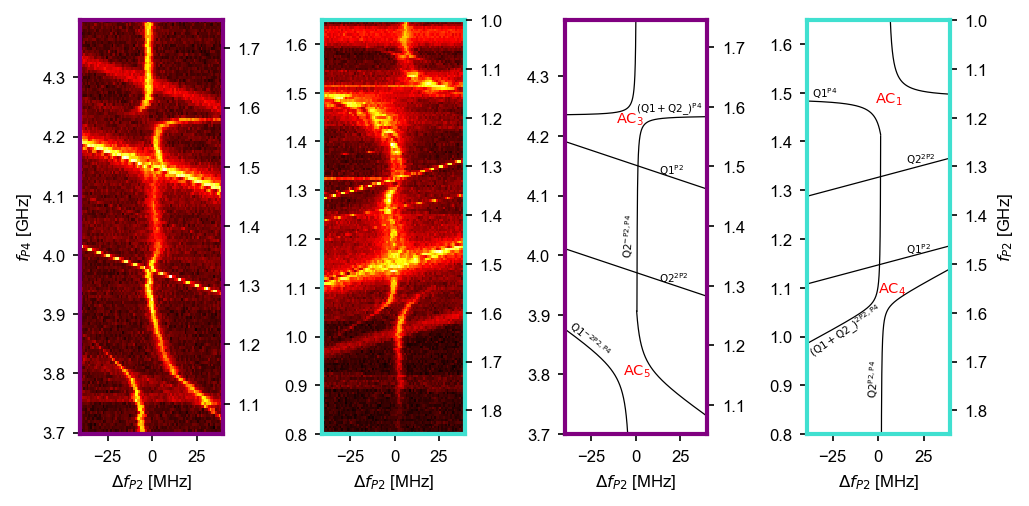

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
import pickle
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import sys
import os
from utils.notebook_tools import get_data_from
import pickle

fig_size_single = 3.37
fig_size_double = 6.69

#%% defining style
plt.rcParams.update({'font.size': 8})
plt.rcParams['font.sans-serif']= 'Arial'
plt.rcParams["figure.figsize"] = (fig_size_single, 3)  #it should be 3 
plt.rcParams['figure.dpi'] = 150
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.default'] = 'it' #'regular'

plt.rcParams['legend.frameon']= True
plt.rcParams['legend.fontsize']= 'small'
plt.rcParams['legend.scatterpoints']= 1
plt.rcParams['axes.labelpad'] = 4 #-2

muB=57.883818060*0.241799050402293  #Bohr magneton in GHz 
B=0.675                             #magnetic field in Tesla 
g10=0.17439208                      #g-factor 
c1=-0.00104254                        
d=-0.01145871
a=0.03582596
g20=0.27062489
c2=-0.00142594
aU=a*10**(-3)

def get_fq1(VP1):   #this function calculates the frequency of qubit 1 at different detunings (VP2=-VP1)

    return (muB*B*(g10-c1*VP1)+2*d*1/(1-4*a**2*VP1**2))

def get_fq1b(VP1):  #this function calculates fQ1_ frequency at different detunings (VP2=-VP1)

    return (muB*B*(g10-c1*VP1)-2*d*1/(1-4*a**2*VP1**2))

def get_fq2(VP1):   #this function calculates the frequency of qubit 2 at different detunings (VP2=-VP1)

    return (muB*B*(g20+c2*VP1)+2*d*1/(1-4*a**2*VP1**2))

def get_fq2b(VP1):  #this function calculates fQ2_ frequency at different detunings (VP2=-VP1)

    return (muB*B*(g20+c2*VP1)-2*d*1/(1-4*a**2*VP1**2))

def EP2(f): #frequency in GHz, EP2 in ueV, calculates the electric field of plunger P2, without the lever arm  
    cucc=1.36+7.28*e**(-0.45*f)
    return cucc*beta*1000 

t_avg=13.3721499
O_avg=7.584879
U=2559.3078425900085
alpha=U*a*10**(-3)

script_dir = os.path.dirname() #<-- absolute dir the script is in
print(script_dir)
sys.path.append(script_dir)
save_path = os.path.join(script_dir, 'Figures')

#%% imports
#%% defining style
fig_size_single = 3.37
fig_size_double = 6.69

plt.rcParams['figure.dpi'] = 150
#%% load data
start_time_q1dif = '2022-07-11\\13-12-41'
start_time_q2dif = '2022-07-12\\14-28-39'
start_time_q2sum = '2022-07-12\\15-39-11'

start_time_list = [start_time_q1dif, start_time_q2dif, start_time_q2sum]
mixing_regime = ['difference', 'difference', 'sum']

datfile = {}

datadir = os.path.join(script_dir, 'measurements')
print(datadir)
for start_time in start_time_list:
    end_time = start_time #'2021-06-24\\18-03-01' #'2021-06-10\\18-32-47'    
    datfiles, fnames = get_data_from(start_time, end_time, num = 1, rootfolder=datadir, only_complete = False) 
    datfile[start_time] = datfiles[0]

start_time_rabi_q1dif = '2022-07-13\\15-26-45'
start_time_rabi_q2dif = '2022-07-13\\14-27-14'
start_time_rabi_q2sum = '2022-07-13\\14-51-17'

start_time_rabi_list = [start_time_rabi_q1dif, start_time_rabi_q2dif, start_time_rabi_q2sum]
mixing_regime = ['difference', 'difference', 'sum']
fp4_fp2 = [(2.6, 1.10064), (4.2, 1.5539), (1.4, 1.2472)]

datfile_rabi = {}

for start_time_rabi in start_time_rabi_list:
    end_time = start_time_rabi #'2021-06-24\\18-03-01' #'2021-06-10\\18-32-47'
    datfiles, fnames = get_data_from(start_time_rabi, end_time, num = 1, rootfolder=datadir, only_complete = False) 
    datfile_rabi[start_time_rabi] = datfiles


#%% Calibrated Rabi frequencies
with open(os.path.join(script_dir, 'measurements\config_freq_rabi.txt'), "rb") as file:
    config_freq_rabi = pickle.load(file)

vP1 = -10
vP2 = 10
P2_pwr = -5
P4_pwr = 3
#aU=0.03583*10**(-3) #1/ueV

try:
    fq2p2 = config_freq_rabi['P2'][P2_pwr]['fq2'][(vP1,vP2)]
    fq2 = fq2p2
    fq1p4 = config_freq_rabi['P4'][P4_pwr]['fq1'][(vP1,vP2)]
    fq1 = fq1p4
except:
    print('Could not find calibrated data in database')
    fq1 = 1.51e9
    fq2 = 2.66e9

# mixing_regime = 'difference'
fq = [fq1/1e9, fq2/1e9, fq2/1e9]


#%% Plotting
fig1 = plt.figure(figsize=(2*fig_size_single, fig_size_single))
# fig2 = plt.figure(figsize=(1.5, 4))

gs1 = GridSpec(nrows=1, ncols=4,wspace=0.7)
# gs2 = GridSpec(nrows=3, ncols=1)

n = 1
ax = []
colors = ['#1f77b4', 'purple', 'turquoise', 'lightskyblue']

ymax=[]
ymin=[]

xmax=[]
xmin=[]

for start_time in start_time_list[1:]:
    ax = fig1.add_subplot(gs1[0,n-1])
    
    delta = datfile[start_time].delta_set.ndarray[0,:]
    
    mixing = datfile[start_time].mixing_set.ndarray
    fp2 = mixing
    if mixing_regime[n] == 'difference':
        fp4 = abs(fp2 - fq[n])
        #ax.scatter([(fq[n]-(fp4_fp2[n][0]-fp4_fp2[n][1]))*1e3],[fp4_fp2[n][0]], s=50, zorder=1, marker='d', color=colors[n], edgecolors='black')
    elif mixing_regime[n] == 'sum':
        fp4 = abs(fq[n] - fp2)
        #ax.scatter([(fq[n]-(fp4_fp2[n][0]+fp4_fp2[n][1]))*1e3],[fp4_fp2[n][0]], s=50, zorder=1, marker='d', color=colors[n], edgecolors='black')
        ax.set_ylim(min(fp4)/1e9, 1.65)
    
    
    ax.pcolor(delta/1e6, fp2/1e9, datfile[start_time].su0, shading='auto', cmap='hot', zorder=0)
    ymax.append(max(fp2/1e9))
    ymin.append(min(fp2/1e9))
    
    xmax.append(max(delta/1e6))
    xmin.append(min(delta/1e6))
    print(xmin)
    print(xmax)
    
    for spine in ax.spines.values():
        spine.set_edgecolor(colors[n])
                            
    if n == 1:
        ax.set_ylabel('$f_{P4}$ [GHz]')
    ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    ax2 = ax.twinx()
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    fp2_max, fp2_min = ax.get_ylim()
    if mixing_regime[n] == 'difference':
        ax2.set_ylim(fp2_max - fq[n], fp2_min - fq[n])
    elif mixing_regime[n] == 'sum':
        ax2.set_ylim(fq[n] - fp2_max, fq[n] - fp2_min)
    #if n == 2:
    #    ax2.set_ylabel('$f_{P2}$ [GHz]')
   
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    for spine in ax2.spines.values():
        spine.set_edgecolor(colors[n]) 
   
    n = n + 1
n=1    
ax3 = []

x=linspace(-40*10**6,38*10**6)
y1=get_fq1(-10)*10**9-x
y2=get_fq2(-10)*10**9/2-x

y3=get_fq1(-10)*10**9+x
y4=get_fq2(-10)*10**9/2+x

s=0

ax3 = fig1.add_subplot(gs1[0,2])
ax3.set_ylim(3.7,4.395)
ax3.set_xlim(-40,40) 
    
ax4 = fig1.add_subplot(gs1[0,3])
ax4.set_ylim(0.8,1.65)   
ax4.set_xlim(-39,39)

ax3.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax4.set_xlabel(r'$\Delta f_{P2}$ [MHz]')

ax5=ax3.twinx()
ax6=ax4.twinx()
ax6.set_ylabel('$f_{P2}$ [GHz]')

ax5.set_ylim(3.7-fq2*10**(-9),4.395-fq2*10**(-9))
ax6.set_ylim(fq2*10**(-9)-0.8,fq2*10**(-9)-1.65)

for spine in ax5.spines.values():
    spine.set_linewidth(2)
    spine.set_edgecolor('purple')

for spine in ax6.spines.values():
    spine.set_linewidth(2)    
    spine.set_edgecolor('turquoise')

x=linspace(-40*10**6,40*10**6)
y1=get_fq1(-10)*10**9-x
y2=get_fq2(-10)*10**9/2-x
ax6.plot(x*10**(-6),y1*10**(-9),color='black',linewidth=0.6)
ax6.plot(x*10**(-6),y2*10**(-9),color='black',linewidth=0.6)

y3=get_fq1(-10)*10**9+x
y4=get_fq2(-10)*10**9/2+x

ax5.plot(x*10**(-6),y1*10**(-9),color='black',linewidth=0.6)
ax5.plot(x*10**(-6),y2*10**(-9),color='black',linewidth=0.6)

def curve_q2diff(x,b0,b1,chi3):
    return (chi3**2-(2*b0+b1)*x-b0*b1-2*x**2)/(x+b0)

b0_AC5=2212535.143443901
b1_AC5=-3803496929.807756

b0=b0_AC5
b1=b1_AC5

x1=linspace(-4*10**7,-0.4*10**7,5000)
x2=linspace(0.039*10**7,4*10**7,5000)

VP=10000

beta=1.231-0.446

chi3_AC5=2*EP2(1.141)*2*VP*t_avg*t_avg*aU**2/(U*(1-aU**2*(2*VP)**2)**2) #ueV
chi3_AC5=chi3_AC5*241799.050402293*10**9*10**(-6)
#print('chi3_AC5: ',chi3_AC5*10**(-6))

ax3.plot(x1*10**(-6),curve_q2diff(x1,b0,b1,chi3_AC5)*10**(-9),color='black',linewidth=0.6)  #lower
ax3.plot(x2*10**(-6),curve_q2diff(x2,b0,b1,chi3_AC5)*10**(-9),color='black',linewidth=0.6)

def curve_q2diff(x,x0,y0,chi3):
    return y0-chi3**2/(x-x0)

x0_AC3=371113.3399685373
y0_AC3=4233829921.6957736

x0=x0_AC3
y0=y0_AC3

chi3_AC3=2*EP2(1.57)*2*VP*t_avg*O_avg*aU**2/(U*(1-aU**2*(2*VP)**2)**2) #ueV
chi3_AC3=chi3_AC3*241799.050402293*10**9*10**(-6)
#print('chi3_AC3: ',chi3_AC3*10**(-6))

x1=linspace(-4*10**7,0.0*10**7,5000)
x2=linspace(0.057*10**7,4*10**7,5000)
ax3.plot(x1*10**(-6),curve_q2diff(x1,x0,y0,chi3_AC3)*10**(-9),color='black',linewidth=0.6)  #uppper
ax3.plot(x2*10**(-6),curve_q2diff(x2,x0,y0,chi3_AC3)*10**(-9),color='black',linewidth=0.6)

def curve_q2sum(x,x0,y0,chi3):
    return y0+chi3**2/(x-x0)

x0_AC1=4917276.093609922
y0_AC1=1489147629.206431

x0=x0_AC1
y0=y0_AC1

chi3_AC1=2*EP2(1.141)*2*VP*t_avg*t_avg*aU**2/(U*(1-aU**2*(2*VP)**2)**2) #ueV
chi3_AC1=chi3_AC1*241799.050402293*10**9*10**(-6)
#print('chi3_AC1: ',chi3_AC1*10**(-6))

x1=linspace(-4*10**7,0.13*10**7,5000)
x2=linspace(0.6*10**7,4*10**7,5000)
ax4.plot(x1*10**(-6),curve_q2sum(x1,x0,y0,chi3_AC1)*10**(-9),color='black',linewidth=0.6)   #upper
ax4.plot(x2*10**(-6),curve_q2sum(x2,x0,y0,chi3_AC1)*10**(-9),color='black',linewidth=0.6)

def curve_q2sum(x,b0,b1,chi3):
    return (chi3**2+(2*b0+b1)*x-b0*b1-2*x**2)/(b0-x)

b0_AC4=1498012.046414408
b1_AC4=-1062066001.0487719

b0=b0_AC4
b1=b1_AC4
x1=linspace(-4*10**7,0.131*10**7,5000)
x2=linspace(0.15*10**7,4*10**7,5000)

chi3_AC4=2*EP2(1.57)*2*VP*t_avg*O_avg*aU**2/(U*(1-aU**2*(2*VP)**2)**2) #ueV
chi3_AC4=chi3_AC4*241799.050402293*10**9*10**(-6)
#print('chi3_AC4: ',chi3_AC4*10**(-6))

ax4.plot(x1*10**(-6),curve_q2sum(x1,b0,b1,chi3_AC4)*10**(-9),color='black',linewidth=0.6)  #lower
ax4.plot(x2*10**(-6),curve_q2sum(x2,b0,b1,chi3_AC4)*10**(-9),color='black',linewidth=0.6)

ax4.text(-7,0.88,'$\mathrm{Q2^{P2,P4}}$',rotation=85,fontsize=5)
ax4.text(15,1.17,'$\mathrm{Q1^{P2}}$',fontsize=5)
ax4.text(15,1.355,'$\mathrm{Q2^{2P2}}$',fontsize=5)
ax4.text(-36,1.49,'$\mathrm{Q1^{P4}}$',fontsize=5)
ax4.text(-39,0.96,'$(\mathrm{Q1}+\mathrm{Q2}\_)^{\mathrm{2P2,P4}}$',rotation=33.69,fontsize=5)

ax3.text(-9,4,'$\mathrm{Q2^{-P2,P4}}$',rotation=85,fontsize=5)
ax3.text(13,4.135,'$\mathrm{Q1^{P2}}$',fontsize=5)
ax3.text(13,3.955,'$\mathrm{Q2^{2P2}}$',fontsize=5)
ax3.text(0,4.24,'$(\mathrm{Q1}+\mathrm{Q2}\_)^{\mathrm{P4}}$',fontsize=5)
ax3.text(-39,3.83,'$\mathrm{Q1^{-2P2,P4}}$',rotation=-39,fontsize=5)

ax4.text(-2,1.48,'$\mathrm{AC_1}$',fontsize=7,color='red')
ax4.text(0,1.09,'$\mathrm{AC_4}$',fontsize=7,color='red')

ax3.text(-11,4.222,'$\mathrm{AC_3}$',fontsize=7,color='red')
ax3.text(-7,3.8,'$\mathrm{AC_5}$',fontsize=7,color='red')

fig1.tight_layout()

plt.subplots_adjust(left=0.07,
                    bottom=0.12,
                    right=0.93,
                    top=0.94,
                    hspace=0)

plt.savefig('Figure3.png', dpi=300)
plt.savefig('Figure3.pdf', dpi=300)
fig1.savefig('Figure3.svg',backend='SVG',bbox_inches="tight")
plt.show()